# Proyecto Machine Learning

# Importo librerias

In [127]:
from catboost import CatBoostRegressor, Pool
import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder , OrdinalEncoder, StandardScaler

## Utils

In [2]:
def data_report(df):
    # Sacamos los NOMBRES
    cols = pd.DataFrame(df.columns.values, columns=["COL_N"])

    # Sacamos los TIPOS
    types = pd.DataFrame(df.dtypes.values, columns=["DATA_TYPE"])

    # Sacamos los MISSINGS
    percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
    percent_missing_df = pd.DataFrame(percent_missing.values, columns=["MISSINGS (%)"])

    # Sacamos los VALORES UNICOS
    unicos = pd.DataFrame(df.nunique().values, columns=["UNIQUE_VALUES"])
    
    percent_cardin = round(unicos['UNIQUE_VALUES']*100/len(df), 2)
    percent_cardin_df = pd.DataFrame(percent_cardin.values, columns=["CARDIN (%)"])

    concatenado = pd.concat([cols, types, percent_missing_df, unicos, percent_cardin_df], axis=1, sort=False)
    concatenado.set_index('COL_N', drop=True, inplace=True)


    return concatenado.T

## Abro el dataset

In [3]:
df = pd.read_csv('googleplaystore.csv')

## Empiezo a explorar

In [4]:
df.shape

(10841, 13)

In [5]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [7]:
df.corr()

C:\Users\Victor\AppData\Local\Temp\ipykernel_8760\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Rating
Rating,1.0


In [8]:
data_report(df)

COL_N,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
DATA_TYPE,object,object,float64,object,object,object,object,object,object,object,object,object,object
MISSINGS (%),0.0,0.0,13.6,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.07,0.03
UNIQUE_VALUES,9660,34,40,6002,462,22,3,93,6,120,1378,2832,33
CARDIN (%),89.11,0.31,0.37,55.36,4.26,0.2,0.03,0.86,0.06,1.11,12.71,26.12,0.3


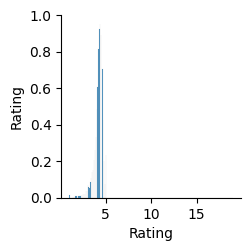

In [9]:
sns.pairplot(df)

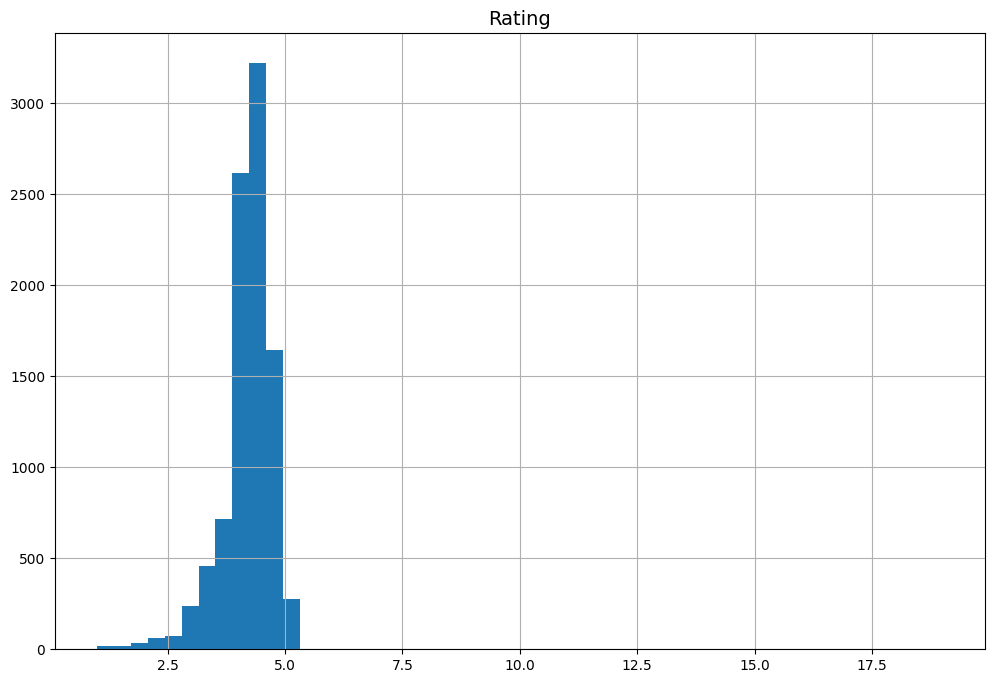

In [10]:
# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(12, 8))
#save_fig("attribute_histogram_plots")  # extra code
plt.show()

## Problema de Machine Learning

Con los datos disponibles quiero predecir el Rating de una app a partir del resto de variables disponibles: 'Category', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver' y 'Android Ver'. Se trata por tanto de crear un modelo de regresion supervisado para resolver el problema.

## Elimino las filas que contienen Missings

Decido eliminar los missings porque la mayoria estan en el target ('Rating') y no tiene sentido estimarlos para luego predecirlos.

In [11]:
df2 = df.copy().dropna(subset=["Rating","Content Rating", "Current Ver", "Android Ver"])
df2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9360 non-null   object 
 1   Category        9360 non-null   object 
 2   Rating          9360 non-null   float64
 3   Reviews         9360 non-null   object 
 4   Size            9360 non-null   object 
 5   Installs        9360 non-null   object 
 6   Type            9360 non-null   object 
 7   Price           9360 non-null   object 
 8   Content Rating  9360 non-null   object 
 9   Genres          9360 non-null   object 
 10  Last Updated    9360 non-null   object 
 11  Current Ver     9360 non-null   object 
 12  Android Ver     9360 non-null   object 
dtypes: float64(1), object(12)
memory usage: 1023.8+ KB


A continuación examino una a una las variables

## Divido el dataset en Train y Test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop('Rating', axis=1),
                                                    df2['Rating'],
                                                    test_size=0.3,
                                                    random_state=42)

## App

Nombre de la aplicación. Podria aportar valor si se analiza en profundidad la semantica de las palabras que contiene, pero en este caso lo descartamos por su complejidad, así que eliminamos la columna del dataFrame.

In [13]:
X_train.drop('App', axis=1, inplace=True)

## Category

Categorica dificil de codificar. Como no son demasiados valores, el one hot enconding parace lo más adecuado.

In [14]:
X_train.Category.value_counts()

FAMILY                 1228
GAME                    768
TOOLS                   513
PRODUCTIVITY            256
MEDICAL                 249
PHOTOGRAPHY             232
PERSONALIZATION         232
FINANCE                 228
COMMUNICATION           222
BUSINESS                217
SPORTS                  209
HEALTH_AND_FITNESS      208
LIFESTYLE               204
SOCIAL                  195
NEWS_AND_MAGAZINES      166
SHOPPING                164
TRAVEL_AND_LOCAL        147
DATING                  126
BOOKS_AND_REFERENCE     119
ENTERTAINMENT           117
VIDEO_PLAYERS           110
EDUCATION               102
MAPS_AND_NAVIGATION      93
FOOD_AND_DRINK           72
WEATHER                  60
LIBRARIES_AND_DEMO       49
HOUSE_AND_HOME           46
AUTO_AND_VEHICLES        46
COMICS                   42
ART_AND_DESIGN           42
EVENTS                   33
PARENTING                32
BEAUTY                   25
Name: Category, dtype: int64

## Reviews

Es un campo numerico pero el tipo es object. Lo cambio a int64.

In [15]:
X_train["Reviews"] = X_train["Reviews"].astype('int64')

In [16]:
X_train["Reviews"].info()

<class 'pandas.core.series.Series'>
Int64Index: 6552 entries, 6816 to 8189
Series name: Reviews
Non-Null Count  Dtype
--------------  -----
6552 non-null   int64
dtypes: int64(1)
memory usage: 102.4 KB


## Size

Es un campo numerico pero el tipo es object. Recoge el tamaño de la app en kb y mb. Lo convertiré todo a MB y cambiare 'Varies with device' por el segundo valor más común (14M) cambio el tipo a float64.

In [17]:
X_train["Size"].value_counts()

Varies with device    1159
14M                    121
15M                    116
12M                    115
11M                    113
                      ... 
371k                     1
506k                     1
82k                      1
976k                     1
376k                     1
Name: Size, Length: 359, dtype: int64

In [18]:
X_train["Size"] = X_train["Size"].replace(['Varies with device'],['14000'])

In [19]:
X_train["Size"].value_counts()

14000    1159
14M       121
15M       116
12M       115
11M       113
         ... 
371k        1
506k        1
82k         1
976k        1
376k        1
Name: Size, Length: 359, dtype: int64

In [20]:
X_train["Size"] = X_train["Size"].apply(lambda x: float(x.replace('M','')) *1000 if 'M' in x else (float(x.replace('k','')) /1000 if 'k' in x else x))

In [21]:
X_train["Size"]=X_train["Size"].astype('float64')

In [22]:
X_train["Size"].info()

<class 'pandas.core.series.Series'>
Int64Index: 6552 entries, 6816 to 8189
Series name: Size
Non-Null Count  Dtype  
--------------  -----  
6552 non-null   float64
dtypes: float64(1)
memory usage: 102.4 KB


In [23]:
X_train["Size"].value_counts()

14000.000    1280
15000.000     116
12000.000     115
11000.000     113
13000.000     111
             ... 
0.371           1
0.506           1
0.082           1
0.976           1
0.376           1
Name: Size, Length: 357, dtype: int64

In [24]:
X_train["Size"].info()

<class 'pandas.core.series.Series'>
Int64Index: 6552 entries, 6816 to 8189
Series name: Size
Non-Null Count  Dtype  
--------------  -----  
6552 non-null   float64
dtypes: float64(1)
memory usage: 102.4 KB


## Installs

Installs es un campo tipo Object que hay que limpiar eliminando '+' y ',' utilizadas como notacion de los miles para transformarlo en un campo tipo 'int64'

In [25]:
X_train.Installs.value_counts()

1,000,000+        1086
10,000,000+        884
100,000+           802
10,000+            708
5,000,000+         522
1,000+             510
500,000+           372
50,000+            333
5,000+             294
100,000,000+       286
100+               210
50,000,000+        208
500+               136
500,000,000+        52
10+                 51
50+                 45
1,000,000,000+      42
5+                   8
1+                   3
Name: Installs, dtype: int64

In [26]:
X_train["Installs"] = X_train["Installs"].str.split('+',expand=True)[0]

In [27]:
X_train["Installs"] = X_train["Installs"].apply(lambda x: x.replace(',',''))

In [28]:
X_train["Installs"] = X_train["Installs"].astype('int64')

In [29]:
X_train.Installs.info()

<class 'pandas.core.series.Series'>
Int64Index: 6552 entries, 6816 to 8189
Series name: Installs
Non-Null Count  Dtype
--------------  -----
6552 non-null   int64
dtypes: int64(1)
memory usage: 102.4 KB


## Genres

En algun caso hay dos generos. Divido usando el ";" como separador, guardo "Main_Genre" para procesarlo despues con un onehot encoding y creo una categoria binaria si tiene o no genero secundario. Al acabar, elimino 'Genres'

In [30]:
X_train["Genres"].str.split(';',expand=True)[1].value_counts()

Action & Adventure    92
Education             69
Pretend Play          62
Brain Games           51
Music & Video         37
Creativity            24
Name: 1, dtype: int64

In [31]:
X_train["Main_Genre"] = X_train["Genres"].str.split(';',expand=True)[0]

In [32]:
X_train["Secondary_Genre"] = X_train["Genres"].str.split(';',expand=True)[1]

In [33]:
X_train["Secondary_Genre"] = X_train["Secondary_Genre"].replace(['Action & Adventure', 'Education', 'Pretend Play', 'Brain Games', 'Music & Video', 'Creativity'],['1', '1','1', '1', '1','1'])

In [34]:
X_train["Secondary_Genre"] = X_train["Secondary_Genre"].fillna('0').astype('int64')

In [35]:
X_train["Secondary_Genre"].value_counts()

0    6217
1     335
Name: Secondary_Genre, dtype: int64

In [36]:
X_train["Secondary_Genre"].info()

<class 'pandas.core.series.Series'>
Int64Index: 6552 entries, 6816 to 8189
Series name: Secondary_Genre
Non-Null Count  Dtype
--------------  -----
6552 non-null   int64
dtypes: int64(1)
memory usage: 102.4 KB


In [37]:
X_train.drop('Genres', axis=1, inplace=True)

In [38]:
X_train.head()

,Category,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated,Current Ver,Android Ver,Main_Genre,Secondary_Genre
6816,FAMILY,7,5600.000,10,Free,0,Everyone,"December 7, 2017",1.0,4.0.3 and up,Education,0
1094,FINANCE,11919,23000.000,1000000,Free,0,Everyone,"July 27, 2018",1.13.2.11,4.4 and up,Finance,0
4089,FAMILY,148536,59000.000,10000000,Free,0,Everyone,"August 3, 2018",4.21.1,4.1 and up,Education,1
4144,SOCIAL,4828372,14000.000,1000000000,Free,0,Teen,"July 26, 2018",Varies with device,Varies with device,Social,0
10050,TOOLS,164,0.144,5000,Paid,$4.99,Everyone,"March 14, 2015",1.3,1.6 and up,Tools,0


## Type

Categorica dificil de codificar. Como solo hay dos valores, el one hot enconding parace lo más adecuado.

## Price

Es un campo numerico pero indica la divisa (Simbolo dolar) y el tipo es object. Elimino '$' y lo cambio a int64.

In [39]:
X_train["Price"] = X_train["Price"].apply(lambda x: x.replace('$',''))

In [40]:
X_train["Price"] = X_train["Price"].astype('float64')

In [41]:
X_train["Price"].info()

<class 'pandas.core.series.Series'>
Int64Index: 6552 entries, 6816 to 8189
Series name: Price
Non-Null Count  Dtype  
--------------  -----  
6552 non-null   float64
dtypes: float64(1)
memory usage: 102.4 KB


## Content Rating

Categorica dificil de codificar. Como no son demasiados valores, el one hot enconding parace lo más adecuado.

## Last Updated

Es una fecha pero no tiene formato (Object). Lo convierto a Date Time y le resto los dias desde la fecha actual para convertirlo en un campo numerico (dias desde la ultima actualizacion).

In [42]:
X_train["Last Updated"] = X_train["Last Updated"].apply(lambda x: x.replace(' ','/').replace(',','').replace('January','1').replace('February','2').replace('March','3').replace('April','4').replace('May','5').replace('June','6').replace('July','7').replace('August','8').replace('September','9').replace('October','10').replace('November','11').replace('December','12'))

In [43]:
df2["Last Updated"] = pd.to_datetime(df2["Last Updated"]).dt.strftime('%d-%m-%Y')

In [44]:
X_train["Last Updated"] = X_train["Last Updated"].astype('datetime64')

In [45]:
timestamp = pd.Timestamp(datetime.datetime(2021, 10, 10))

In [46]:
print("Timestamp: ", timestamp)

Timestamp:  2021-10-10 00:00:00


In [47]:
ahora = pd.Timestamp(timestamp.today().strftime('%d-%m-%Y'))

In [48]:
X_train['Today'] = ahora

In [49]:
X_train['Today'] = X_train['Today'].astype('datetime64')

C:\Users\Victor\AppData\Local\Temp\ipykernel_8760\539780938.py:1: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  X_train['Today'] = X_train['Today'].astype('datetime64')


In [50]:
X_train['Days_Since_Last_Update'] = (X_train['Today'] - X_train["Last Updated"]).dt.days

In [51]:
X_train['Days_Since_Last_Update']

6816     2034
1094     1802
4089     1795
4144     1803
10050    3033
         ... 
6144     2327
5516     1793
5728     1833
913      1809
8189     2229
Name: Days_Since_Last_Update, Length: 6552, dtype: int64

In [52]:
X_train.drop(['Today','Last Updated'], axis=1, inplace=True)

## Current Ver

Categorica dificil de codificar. El ordinal encoding parece lo más indicado para que el modelo recoja la información (menos frecuencia, versión mas desarrollada)

In [53]:
X_train['Current Ver'].value_counts()

Varies with device    982
1.0                   318
1.1                   143
1.3                    88
2.0                    87
                     ... 
2.12.0                  1
SolarCT 1.9 v           1
3.1.7.9                 1
0.0.5                   1
4.8.6                   1
Name: Current Ver, Length: 2074, dtype: int64

## Android Ver

Categorica dificil de codificar. El ordinal encoding parece lo más indicado para que el modelo recoja la información (menos frecuencia, versión mas desarrollada)

In [54]:
X_train['Android Ver'].value_counts()

4.1 and up            1436
Varies with device     927
4.0.3 and up           880
4.0 and up             794
4.4 and up             617
2.3 and up             417
5.0 and up             360
4.2 and up             238
2.3.3 and up           176
2.2 and up             145
4.3 and up             145
3.0 and up             132
2.1 and up              74
1.6 and up              65
6.0 and up              31
7.0 and up              27
3.2 and up              23
2.0 and up              21
1.5 and up              10
5.1 and up              10
2.0.1 and up             5
3.1 and up               5
4.4W and up              5
8.0 and up               3
7.1 and up               2
5.0 - 8.0                2
4.0.3 - 7.1.1            1
1.0 and up               1
Name: Android Ver, dtype: int64

In [55]:
X_train.corr()

C:\Users\Victor\AppData\Local\Temp\ipykernel_8760\131534602.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  X_train.corr()


,Reviews,Size,Installs,Price,Secondary_Genre,Days_Since_Last_Update
Reviews,1.000000,0.102087,0.638967,-0.009759,-0.015593,-0.090289
Size,0.102087,1.000000,0.040382,-0.024835,0.180698,-0.194460
Installs,0.638967,0.040382,1.000000,-0.011768,-0.024198,-0.105812
Price,-0.009759,-0.024835,-0.011768,1.000000,-0.006789,0.008790
Secondary_Genre,-0.015593,0.180698,-0.024198,-0.006789,1.000000,-0.014806
Days_Since_Last_Update,-0.090289,-0.194460,-0.105812,0.008790,-0.014806,1.000000


In [56]:
data_report(X_train)

COL_N,Category,Reviews,Size,Installs,Type,Price,Content Rating,Current Ver,Android Ver,Main_Genre,Secondary_Genre,Days_Since_Last_Update
DATA_TYPE,object,int64,float64,int64,object,float64,object,object,object,object,int64,int64
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,33,4437,357,19,2,59,6,2074,28,47,2,1147
CARDIN (%),0.5,67.72,5.45,0.29,0.03,0.9,0.09,31.65,0.43,0.72,0.03,17.51


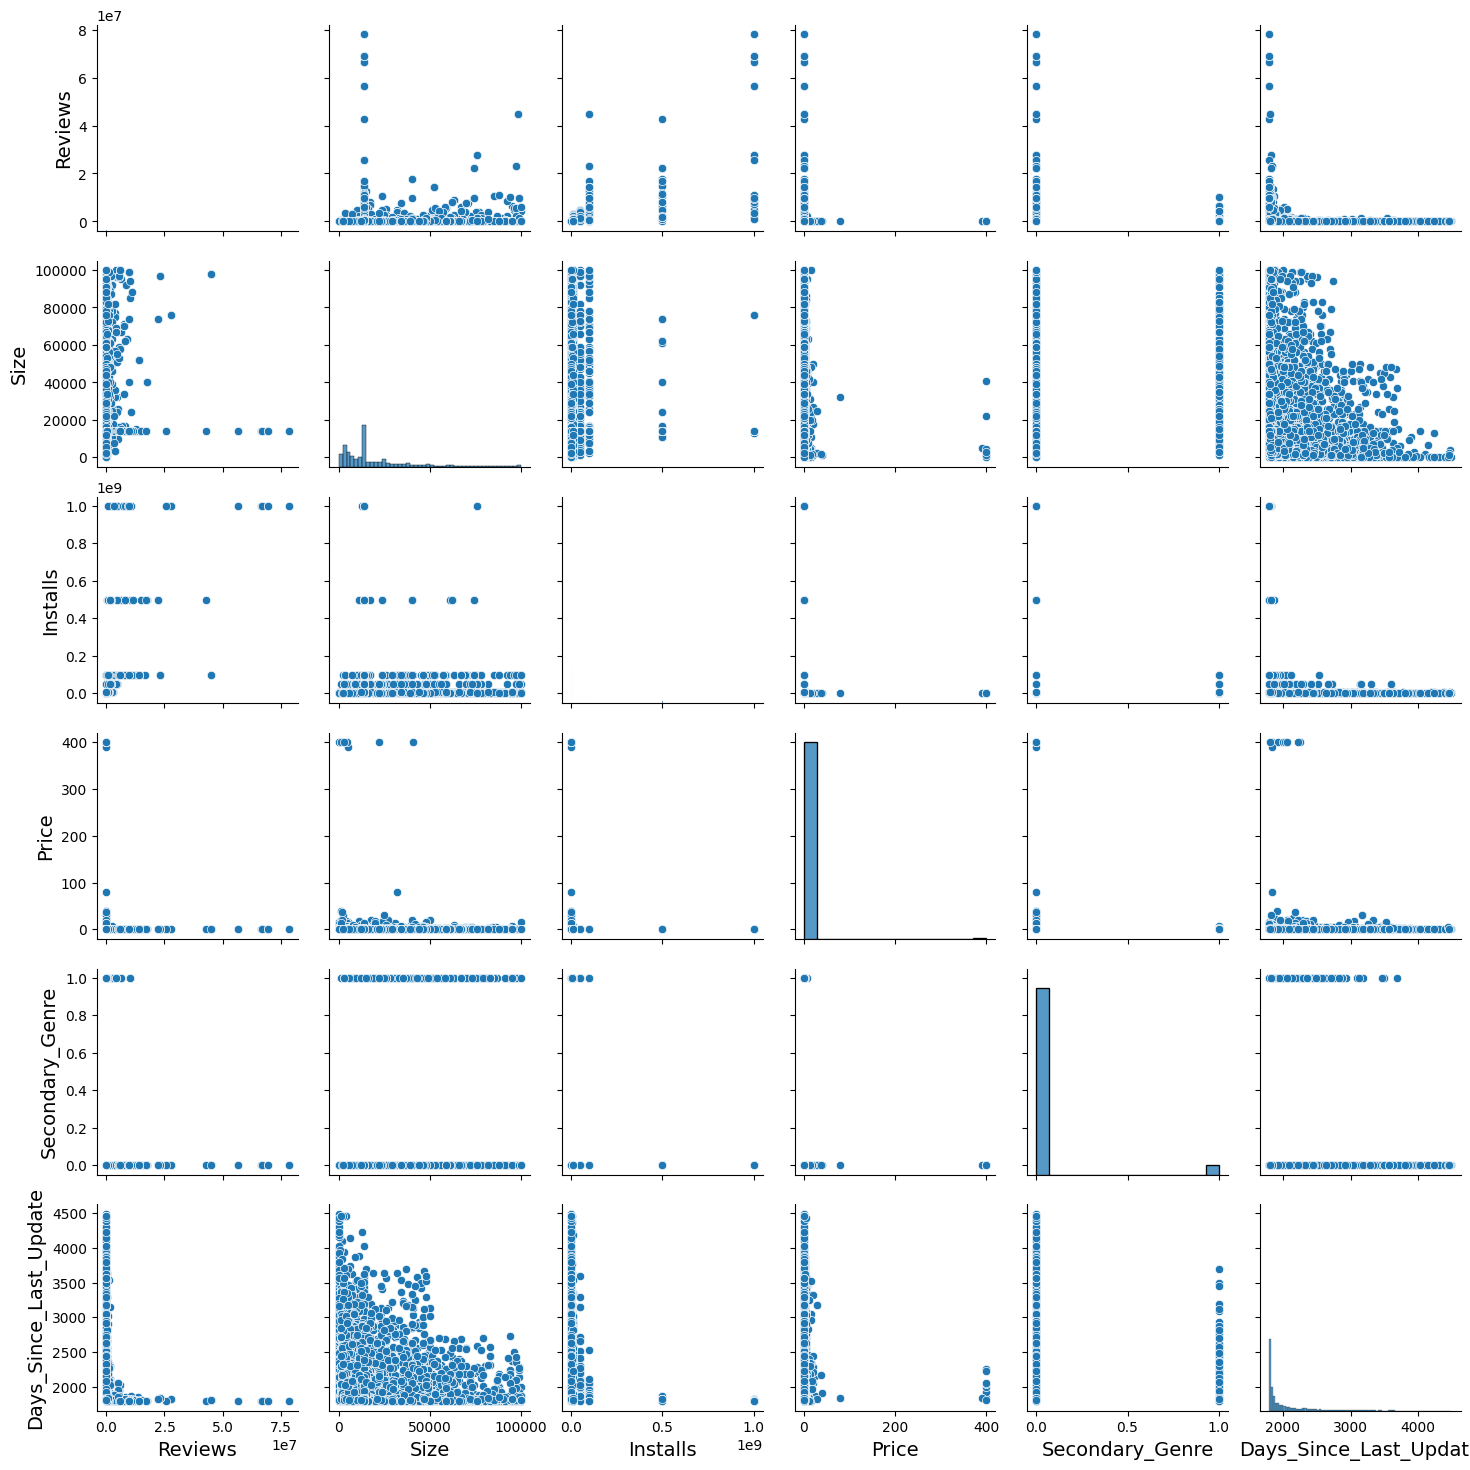

In [57]:
sns.pairplot(X_train)

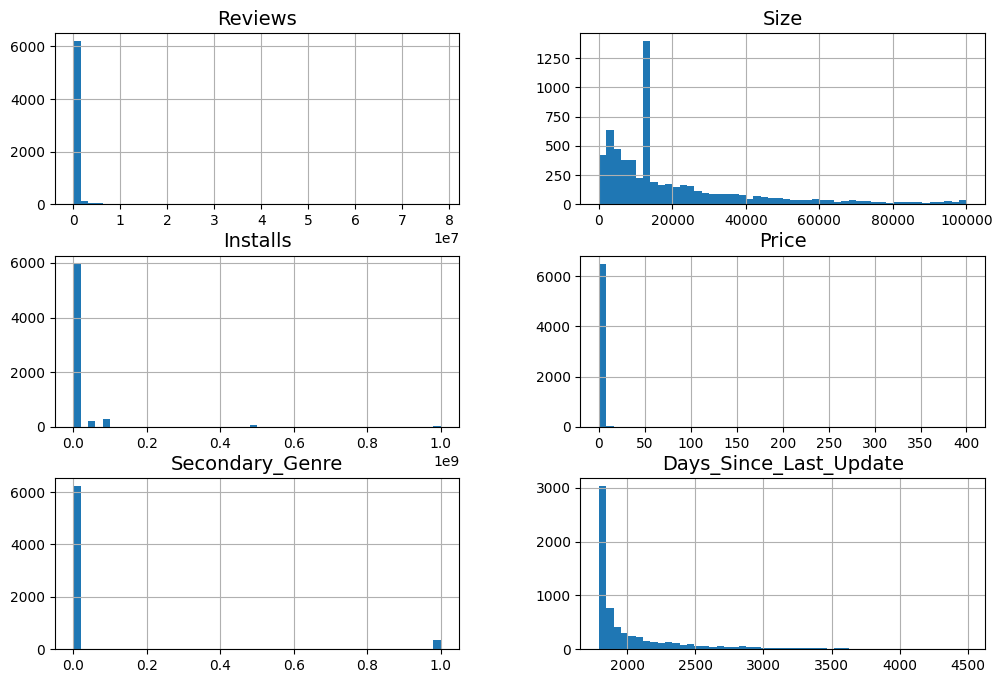

In [58]:
# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

X_train.hist(bins=50, figsize=(12, 8))
#save_fig("attribute_histogram_plots")  # extra code
plt.show()

In [59]:
X_train.head()

,Category,Reviews,Size,Installs,Type,Price,Content Rating,Current Ver,Android Ver,Main_Genre,Secondary_Genre,Days_Since_Last_Update
6816,FAMILY,7,5600.000,10,Free,0.00,Everyone,1.0,4.0.3 and up,Education,0,2034
1094,FINANCE,11919,23000.000,1000000,Free,0.00,Everyone,1.13.2.11,4.4 and up,Finance,0,1802
4089,FAMILY,148536,59000.000,10000000,Free,0.00,Everyone,4.21.1,4.1 and up,Education,1,1795
4144,SOCIAL,4828372,14000.000,1000000000,Free,0.00,Teen,Varies with device,Varies with device,Social,0,1803
10050,TOOLS,164,0.144,5000,Paid,4.99,Everyone,1.3,1.6 and up,Tools,0,3033


## Preprocesado

In [60]:
X_train_clean = X_train.copy()

In [61]:
X_train_clean.head()

,Category,Reviews,Size,Installs,Type,Price,Content Rating,Current Ver,Android Ver,Main_Genre,Secondary_Genre,Days_Since_Last_Update
6816,FAMILY,7,5600.000,10,Free,0.00,Everyone,1.0,4.0.3 and up,Education,0,2034
1094,FINANCE,11919,23000.000,1000000,Free,0.00,Everyone,1.13.2.11,4.4 and up,Finance,0,1802
4089,FAMILY,148536,59000.000,10000000,Free,0.00,Everyone,4.21.1,4.1 and up,Education,1,1795
4144,SOCIAL,4828372,14000.000,1000000000,Free,0.00,Teen,Varies with device,Varies with device,Social,0,1803
10050,TOOLS,164,0.144,5000,Paid,4.99,Everyone,1.3,1.6 and up,Tools,0,3033


## Codificación de Variables Categóricas

In [62]:
oH_cat_pipeline = Pipeline(
    [("OHEncoder", OneHotEncoder())
    ]
)

ord_cat_pipeline = Pipeline(
    [("OrdEncoder", OrdinalEncoder())
    ]
)

num_pipeline = Pipeline(
    [("SScaler", StandardScaler())
    ]
)

'''
dim_reduc_pipeline = Pipeline(
    [("PCA", PCA())
    ]
)
'''

'\ndim_reduc_pipeline = Pipeline(\n    [("PCA", PCA())\n    ]\n)\n'

In [63]:
preprocessing = ColumnTransformer(
    [("OH_Process_Categorical", oH_cat_pipeline, ["Category","Type","Content Rating","Main_Genre"]),
     ("Ord_Process_Categorical", ord_cat_pipeline, ["Current Ver","Android Ver"]),
     ("Process_Num_Scaler", num_pipeline, ["Reviews","Size","Installs","Price","Days_Since_Last_Update"]),
    ], remainder = "passthrough")

In [64]:
pipe_preprocessed_train = preprocessing.fit_transform(X_train_clean)

In [65]:
preprocessing.get_feature_names_out()

array(['OH_Process_Categorical__Category_ART_AND_DESIGN',
       'OH_Process_Categorical__Category_AUTO_AND_VEHICLES',
       'OH_Process_Categorical__Category_BEAUTY',
       'OH_Process_Categorical__Category_BOOKS_AND_REFERENCE',
       'OH_Process_Categorical__Category_BUSINESS',
       'OH_Process_Categorical__Category_COMICS',
       'OH_Process_Categorical__Category_COMMUNICATION',
       'OH_Process_Categorical__Category_DATING',
       'OH_Process_Categorical__Category_EDUCATION',
       'OH_Process_Categorical__Category_ENTERTAINMENT',
       'OH_Process_Categorical__Category_EVENTS',
       'OH_Process_Categorical__Category_FAMILY',
       'OH_Process_Categorical__Category_FINANCE',
       'OH_Process_Categorical__Category_FOOD_AND_DRINK',
       'OH_Process_Categorical__Category_GAME',
       'OH_Process_Categorical__Category_HEALTH_AND_FITNESS',
       'OH_Process_Categorical__Category_HOUSE_AND_HOME',
       'OH_Process_Categorical__Category_LIBRARIES_AND_DEMO',
       'OH

In [66]:
pipe_preprocessed_train

<6552x96 sparse matrix of type '<class 'numpy.float64'>'
	with 72400 stored elements in Compressed Sparse Row format>

In [67]:
df_pipe_train = pd.DataFrame(pipe_preprocessed_train.toarray(), columns= preprocessing.get_feature_names_out())

## Pruebo un CatBoost Regressor con el conjunto de Train:

In [69]:
cb = CatBoostRegressor(n_estimators=200,
                      loss_function='RMSE',
                      learning_rate=0.4,
                      random_state=1
                       # verbose=False
                      )

pool_train = Pool(X_train, y_train,
                 cat_features=['Category','Type','Content Rating','Current Ver','Android Ver','Main_Genre'])
#pool_test = Pool(X_test)

cb.fit(pool_train)

y_pred_train = cb.predict(pool_train)

0:	learn: 0.5005023	total: 185ms	remaining: 36.9s
1:	learn: 0.4937892	total: 210ms	remaining: 20.8s
2:	learn: 0.4860890	total: 238ms	remaining: 15.6s
3:	learn: 0.4831413	total: 266ms	remaining: 13s
4:	learn: 0.4807569	total: 293ms	remaining: 11.4s
5:	learn: 0.4765293	total: 320ms	remaining: 10.3s
6:	learn: 0.4747946	total: 347ms	remaining: 9.55s
7:	learn: 0.4724270	total: 375ms	remaining: 8.99s
8:	learn: 0.4692050	total: 404ms	remaining: 8.58s
9:	learn: 0.4672820	total: 441ms	remaining: 8.39s
10:	learn: 0.4658679	total: 468ms	remaining: 8.04s
11:	learn: 0.4638053	total: 493ms	remaining: 7.73s
12:	learn: 0.4627258	total: 518ms	remaining: 7.45s
13:	learn: 0.4614197	total: 544ms	remaining: 7.23s
14:	learn: 0.4587225	total: 573ms	remaining: 7.07s
15:	learn: 0.4582848	total: 600ms	remaining: 6.89s
16:	learn: 0.4568183	total: 626ms	remaining: 6.73s
17:	learn: 0.4552082	total: 652ms	remaining: 6.6s
18:	learn: 0.4536829	total: 679ms	remaining: 6.47s
19:	learn: 0.4522231	total: 710ms	remaining:

In [70]:
mean_absolute_error(y_train, y_pred)

0.2432242942219778

## Pruebo un CatBoost Regressor con el conjunto de df_pipe_train:

In [113]:
cb_pipe = CatBoostRegressor(n_estimators=200,
                      loss_function='RMSE',
                      learning_rate=0.4,
                      random_state=1
                       # verbose=False
                      )

pool_train_pipe = Pool(df_pipe_train, y_train)
#pool_test = Pool(X_test)

cb_pipe.fit(pool_train_pipe)

y_pred_pipe = cb_pipe.predict(pool_train_pipe)

0:	learn: 0.5026388	total: 3.46ms	remaining: 688ms
1:	learn: 0.4939014	total: 5.98ms	remaining: 592ms
2:	learn: 0.4888427	total: 8.23ms	remaining: 540ms
3:	learn: 0.4844805	total: 10.9ms	remaining: 533ms
4:	learn: 0.4811643	total: 13.1ms	remaining: 513ms
5:	learn: 0.4767900	total: 15.6ms	remaining: 505ms
6:	learn: 0.4736018	total: 17.9ms	remaining: 494ms
7:	learn: 0.4701607	total: 20.1ms	remaining: 484ms
8:	learn: 0.4650059	total: 22.4ms	remaining: 475ms
9:	learn: 0.4627194	total: 24.7ms	remaining: 470ms
10:	learn: 0.4599709	total: 27ms	remaining: 464ms
11:	learn: 0.4582518	total: 29.7ms	remaining: 465ms
12:	learn: 0.4556370	total: 32.3ms	remaining: 465ms
13:	learn: 0.4541819	total: 35.2ms	remaining: 467ms
14:	learn: 0.4515265	total: 37.1ms	remaining: 458ms
15:	learn: 0.4502893	total: 39ms	remaining: 449ms
16:	learn: 0.4484155	total: 41.1ms	remaining: 442ms
17:	learn: 0.4471967	total: 43.2ms	remaining: 437ms
18:	learn: 0.4455046	total: 45.4ms	remaining: 433ms
19:	learn: 0.4449798	total

In [114]:
mean_absolute_error(y_train, y_pred_pipe)

0.2078341515461114

## Limpio el conjunto de test igual que el de Train

## App

Nombre de la aplicación. Podria aportar valor si se analiza en profundidad la semantica de las palabras que contiene, pero en este caso lo descartamos por su complejidad, así que eliminamos la columna del dataFrame.

In [71]:
X_test.drop('App', axis=1, inplace=True)

## Category

Categorica dificil de codificar. Como no son demasiados valores, el one hot enconding parace lo más adecuado.

In [72]:
X_test.Category.value_counts()

FAMILY                 518
GAME                   329
TOOLS                  220
SPORTS                 110
LIFESTYLE              110
COMMUNICATION          106
MEDICAL                101
PRODUCTIVITY            95
FINANCE                 95
HEALTH_AND_FITNESS      89
BUSINESS                86
PHOTOGRAPHY             85
PERSONALIZATION         80
TRAVEL_AND_LOCAL        79
SHOPPING                74
DATING                  69
NEWS_AND_MAGAZINES      67
SOCIAL                  64
BOOKS_AND_REFERENCE     59
EDUCATION               53
VIDEO_PLAYERS           50
FOOD_AND_DRINK          37
ENTERTAINMENT           32
MAPS_AND_NAVIGATION     31
HOUSE_AND_HOME          30
AUTO_AND_VEHICLES       27
ART_AND_DESIGN          19
PARENTING               18
BEAUTY                  17
COMICS                  16
LIBRARIES_AND_DEMO      15
WEATHER                 15
EVENTS                  12
Name: Category, dtype: int64

## Reviews

Es un campo numerico pero el tipo es object. Lo cambio a int64.

In [73]:
X_test["Reviews"] = X_test["Reviews"].astype('int64')

In [74]:
X_test["Reviews"].info()

<class 'pandas.core.series.Series'>
Int64Index: 2808 entries, 5560 to 2736
Series name: Reviews
Non-Null Count  Dtype
--------------  -----
2808 non-null   int64
dtypes: int64(1)
memory usage: 43.9 KB


## Size

Es un campo numerico pero el tipo es object. Recoge el tamaño de la app en kb y mb. Lo convertiré todo a MB y cambiare 'Varies with device' por el segundo valor más común (14M) cambio el tipo a float64.

In [75]:
X_test["Size"].value_counts()

Varies with device    478
25M                    50
13M                    46
11M                    46
12M                    46
                     ... 
209k                    1
924k                    1
121k                    1
206k                    1
516k                    1
Name: Size, Length: 249, dtype: int64

In [76]:
X_test["Size"] = X_test["Size"].replace(['Varies with device'],['14000'])

In [77]:
X_test["Size"].value_counts()

14000    478
25M       50
13M       46
11M       46
12M       46
        ... 
209k       1
924k       1
121k       1
206k       1
516k       1
Name: Size, Length: 249, dtype: int64

In [78]:
X_test["Size"] = X_test["Size"].apply(lambda x: float(x.replace('M','')) *1000 if 'M' in x else (float(x.replace('k','')) /1000 if 'k' in x else x))

In [79]:
X_test["Size"]=X_test["Size"].astype('float64')

In [80]:
X_test["Size"].info()

<class 'pandas.core.series.Series'>
Int64Index: 2808 entries, 5560 to 2736
Series name: Size
Non-Null Count  Dtype  
--------------  -----  
2808 non-null   float64
dtypes: float64(1)
memory usage: 43.9 KB


In [81]:
X_test["Size"].value_counts()

14000.000    522
25000.000     50
13000.000     46
12000.000     46
11000.000     46
            ... 
0.209          1
0.924          1
0.121          1
0.206          1
0.516          1
Name: Size, Length: 247, dtype: int64

In [82]:
X_test["Size"].info()

<class 'pandas.core.series.Series'>
Int64Index: 2808 entries, 5560 to 2736
Series name: Size
Non-Null Count  Dtype  
--------------  -----  
2808 non-null   float64
dtypes: float64(1)
memory usage: 43.9 KB


## Installs

Installs es un campo tipo Object que hay que limpiar eliminando '+' y ',' utilizadas como notacion de los miles para transformarlo en un campo tipo 'int64'

In [83]:
X_test.Installs.value_counts()

1,000,000+        490
10,000,000+       368
100,000+          348
10,000+           301
5,000,000+        230
1,000+            202
500,000+          165
5,000+            137
50,000+           133
100,000,000+      123
100+               99
50,000,000+        81
500+               65
500,000,000+       20
10+                18
1,000,000,000+     16
50+                11
5+                  1
Name: Installs, dtype: int64

In [84]:
X_test["Installs"] = X_test["Installs"].str.split('+',expand=True)[0]

In [85]:
X_test["Installs"] = X_test["Installs"].apply(lambda x: x.replace(',',''))

In [86]:
X_test["Installs"] = X_test["Installs"].astype('int64')

In [87]:
X_test.Installs.info()

<class 'pandas.core.series.Series'>
Int64Index: 2808 entries, 5560 to 2736
Series name: Installs
Non-Null Count  Dtype
--------------  -----
2808 non-null   int64
dtypes: int64(1)
memory usage: 43.9 KB


## Genres

En algun caso hay dos generos. Divido usando el ";" como separador, guardo "Main_Genre" para procesarlo despues con un onehot encoding y creo una categoria binaria si tiene o no genero secundario. Al acabar, elimino 'Genres'

In [88]:
X_test["Genres"].str.split(';',expand=True)[1].value_counts()

Action & Adventure    43
Education             38
Pretend Play          27
Brain Games           18
Creativity            12
Music & Video         10
Name: 1, dtype: int64

In [89]:
X_test["Main_Genre"] = X_test["Genres"].str.split(';',expand=True)[0]

In [90]:
X_test["Secondary_Genre"] = X_test["Genres"].str.split(';',expand=True)[1]

In [91]:
X_test["Secondary_Genre"] = X_test["Secondary_Genre"].replace(['Action & Adventure', 'Education', 'Pretend Play', 'Brain Games', 'Music & Video', 'Creativity'],['1', '1','1', '1', '1','1'])

In [92]:
X_test["Secondary_Genre"] = X_test["Secondary_Genre"].fillna('0').astype('int64')

In [93]:
X_test["Secondary_Genre"].value_counts()

0    2660
1     148
Name: Secondary_Genre, dtype: int64

In [94]:
X_test["Secondary_Genre"].info()

<class 'pandas.core.series.Series'>
Int64Index: 2808 entries, 5560 to 2736
Series name: Secondary_Genre
Non-Null Count  Dtype
--------------  -----
2808 non-null   int64
dtypes: int64(1)
memory usage: 43.9 KB


In [95]:
X_test.drop('Genres', axis=1, inplace=True)

In [96]:
X_test.head()

,Category,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated,Current Ver,Android Ver,Main_Genre,Secondary_Genre
5560,BUSINESS,25195,21000.0,1000000,Free,0,Everyone,"February 26, 2018",v3.4.0-3,4.0.3 and up,Business,0
2895,PHOTOGRAPHY,351254,4000.0,10000000,Free,0,Everyone,"June 29, 2018",4.6.0.0,4.2 and up,Photography,0
7836,GAME,112565,32000.0,1000000,Free,0,Teen,"July 21, 2018",1.1.97,4.4 and up,Action,0
9116,HEALTH_AND_FITNESS,131,3400.0,5000,Free,0,Everyone,"April 1, 2016",1.06,1.6 and up,Health & Fitness,0
598,DATING,187,19000.0,10000,Free,0,Mature 17+,"July 26, 2018",1.17,4.2 and up,Dating,0


## Type

Categorica dificil de codificar. Como solo hay dos valores, el one hot enconding parace lo más adecuado.

## Price

Es un campo numerico pero indica la divisa (Simbolo dolar) y el tipo es object. Elimino '$' y lo cambio a int64.

In [97]:
X_test["Price"] = X_test["Price"].apply(lambda x: x.replace('$',''))

In [98]:
X_test["Price"] = X_test["Price"].astype('float64')

In [99]:
X_test["Price"].info()

<class 'pandas.core.series.Series'>
Int64Index: 2808 entries, 5560 to 2736
Series name: Price
Non-Null Count  Dtype  
--------------  -----  
2808 non-null   float64
dtypes: float64(1)
memory usage: 43.9 KB


## Content Rating

Categorica dificil de codificar. Como no son demasiados valores, el one hot enconding parace lo más adecuado.

## Last Updated

Es una fecha pero no tiene formato (Object). Lo convierto a Date Time y le resto los dias desde la fecha actual para convertirlo en un campo numerico (dias desde la ultima actualizacion).

In [100]:
X_test["Last Updated"] = X_test["Last Updated"].apply(lambda x: x.replace(' ','/').replace(',','').replace('January','1').replace('February','2').replace('March','3').replace('April','4').replace('May','5').replace('June','6').replace('July','7').replace('August','8').replace('September','9').replace('October','10').replace('November','11').replace('December','12'))

In [101]:
X_test["Last Updated"] = X_test["Last Updated"].astype('datetime64')

In [102]:
timestamp = pd.Timestamp(datetime.datetime(2021, 10, 10))

In [103]:
print("Timestamp: ", timestamp)

Timestamp:  2021-10-10 00:00:00


In [104]:
ahora = pd.Timestamp(timestamp.today().strftime('%d-%m-%Y'))

In [105]:
X_test['Today'] = ahora

In [106]:
X_test['Today'] = X_test['Today'].astype('datetime64')

C:\Users\Victor\AppData\Local\Temp\ipykernel_8760\165914949.py:1: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  X_test['Today'] = X_test['Today'].astype('datetime64')


In [107]:
X_test['Days_Since_Last_Update'] = (X_test['Today'] - X_test["Last Updated"]).dt.days

In [108]:
X_test['Days_Since_Last_Update']

5560    1953
2895    1830
7836    1808
9116    2649
598     1803
        ... 
5518    1797
2350    1803
6321    2072
5297    2240
2736    1816
Name: Days_Since_Last_Update, Length: 2808, dtype: int64

In [109]:
X_test.drop(['Today','Last Updated'], axis=1, inplace=True)

## Current Ver

Categorica dificil de codificar. El ordinal encoding parece lo más indicado para que el modelo recoja la información (menos frecuencia, versión mas desarrollada)

In [110]:
X_test['Current Ver'].value_counts()

Varies with device    433
1.0                   140
1.1                    51
1.2                    43
1.3                    32
                     ... 
1.0.10.5                1
4.16.0                  1
1.0060.b0060            1
3.1.6z                  1
1.29                    1
Name: Current Ver, Length: 1174, dtype: int64

## Android Ver

Categorica dificil de codificar. El ordinal encoding parece lo más indicado para que el modelo recoja la información (menos frecuencia, versión mas desarrollada)

In [115]:
X_test_clean = X_test.copy()

## Pruebo un CatBoost Regressor con el conjunto de Test:

In [111]:
pool_test = Pool(X_test, y_test,
                 cat_features=['Category','Type','Content Rating','Current Ver','Android Ver','Main_Genre'])

cb.fit(pool_test)

y_pred_test = cb.predict(pool_test)

0:	learn: 0.4939667	total: 24.2ms	remaining: 4.83s
1:	learn: 0.4846450	total: 56.1ms	remaining: 5.56s
2:	learn: 0.4778948	total: 86.1ms	remaining: 5.65s
3:	learn: 0.4737920	total: 123ms	remaining: 6.01s
4:	learn: 0.4708193	total: 159ms	remaining: 6.19s
5:	learn: 0.4673239	total: 189ms	remaining: 6.11s
6:	learn: 0.4640658	total: 223ms	remaining: 6.15s
7:	learn: 0.4595185	total: 255ms	remaining: 6.11s
8:	learn: 0.4567595	total: 284ms	remaining: 6.03s
9:	learn: 0.4538704	total: 310ms	remaining: 5.9s
10:	learn: 0.4516644	total: 337ms	remaining: 5.78s
11:	learn: 0.4489504	total: 362ms	remaining: 5.67s
12:	learn: 0.4477266	total: 386ms	remaining: 5.55s
13:	learn: 0.4425433	total: 409ms	remaining: 5.44s
14:	learn: 0.4404348	total: 435ms	remaining: 5.36s
15:	learn: 0.4379677	total: 460ms	remaining: 5.29s
16:	learn: 0.4348757	total: 486ms	remaining: 5.23s
17:	learn: 0.4341849	total: 512ms	remaining: 5.18s
18:	learn: 0.4294066	total: 539ms	remaining: 5.13s
19:	learn: 0.4266641	total: 564ms	remai

In [112]:
mean_absolute_error(y_test, y_pred)

0.23604130646201996

# Pruebo CatBoost con conjunto de test preprocesado con Pipeline

In [116]:
pipe_preprocessed_test = preprocessing.fit_transform(X_test_clean)

In [117]:
pipe_preprocessed_test

<2808x96 sparse matrix of type '<class 'numpy.float64'>'
	with 31034 stored elements in Compressed Sparse Row format>

In [118]:
df_pipe_test = pd.DataFrame(pipe_preprocessed_test.toarray(), columns= preprocessing.get_feature_names_out())

In [119]:
pool_test_pipe = Pool(df_pipe_test, y_test)

cb_pipe.fit(pool_test_pipe)

y_pred_pipe_test = cb_pipe.predict(pool_test_pipe)

0:	learn: 0.4937932	total: 2.23ms	remaining: 444ms
1:	learn: 0.4880479	total: 4.85ms	remaining: 480ms
2:	learn: 0.4805466	total: 7.39ms	remaining: 486ms
3:	learn: 0.4733259	total: 9.25ms	remaining: 453ms
4:	learn: 0.4702068	total: 11ms	remaining: 430ms
5:	learn: 0.4628942	total: 14.4ms	remaining: 466ms
6:	learn: 0.4591513	total: 16.5ms	remaining: 454ms
7:	learn: 0.4556806	total: 18.2ms	remaining: 437ms
8:	learn: 0.4529224	total: 20.2ms	remaining: 428ms
9:	learn: 0.4491969	total: 22ms	remaining: 419ms
10:	learn: 0.4466132	total: 24ms	remaining: 413ms
11:	learn: 0.4445620	total: 26.1ms	remaining: 408ms
12:	learn: 0.4396912	total: 28.6ms	remaining: 411ms
13:	learn: 0.4376519	total: 30.7ms	remaining: 407ms
14:	learn: 0.4342555	total: 32.4ms	remaining: 400ms
15:	learn: 0.4321727	total: 34.3ms	remaining: 394ms
16:	learn: 0.4285407	total: 36.4ms	remaining: 391ms
17:	learn: 0.4255198	total: 38.3ms	remaining: 388ms
18:	learn: 0.4226693	total: 40.3ms	remaining: 384ms
19:	learn: 0.4204530	total: 

In [120]:
mean_absolute_error(y_test, y_pred_pipe_test)

0.15636704975919907

In [122]:
corr_matrix = df_pipe_test.corr()

In [126]:
corr_matrix["Process_Num_Scaler__Installs"].sort_values(ascending=False)

Process_Num_Scaler__Installs                        1.000000
Process_Num_Scaler__Reviews                         0.650262
Ord_Process_Categorical__Android Ver                0.176380
Ord_Process_Categorical__Current Ver                0.148286
OH_Process_Categorical__Main_Genre_Communication    0.122419
                                                      ...   
OH_Process_Categorical__Main_Genre_Education       -0.040751
OH_Process_Categorical__Content Rating_Everyone    -0.043444
OH_Process_Categorical__Type_Paid                  -0.050324
OH_Process_Categorical__Category_FAMILY            -0.063469
Process_Num_Scaler__Days_Since_Last_Update         -0.100963
Name: Process_Num_Scaler__Installs, Length: 96, dtype: float64

In [130]:
final_rmse = mean_squared_error(y_test, y_pred_pipe_test, squared=False)
print(final_rmse)

0.210642199800071


In [131]:
final_rmse = mean_squared_error(y_test, y_pred_pipe_test)
print(final_rmse)

0.044370136336613034


## Grid_search

In [132]:
from sklearn.model_selection import GridSearchCV

In [140]:
# RANDOM FOREST
grid_random_forest = {"n_estimators": [100,120], # El Random Forest no suele empeorar por exceso de
                                             # estimadores. A partir de cierto numero no merece la pena
                                             # perder el tiempo ya que no mejora mucho más la precisión.
                                             # Entre 100 y 200 es una buena cifra

                     
                     "max_depth": [3,4,5], # No le afecta tanto el overfitting como al decissiontree.
                                                      # Podemos probar mayores profundidades
                      
                     "max_features": [3, 4, 6] # Numero de features que utiliza en cada split.
                                                    # cuanto más bajo, mejor generalizará y menos overfitting.
                                                    
                     }


'\n# GRADIENT BOOSTING\ngrid_gradient_boosting = {"gradientboostingclassifier__loss": ["deviance"], # Deviance suele ir mejor.\n                          "gradientboostingclassifier__learning_rate": [0.05, 0.1, 0.2, 0.4],  # Cuanto más alto, mas aporta cada nuevo arbol\n                          \n                          "gradientboostingclassifier__n_estimators": [20,50,100], # Cuidado con poner muchos estiamdores ya que vamos a\n                                                           # sobreajustar el modelo\n                          \n                          "gradientboostingclassifier__max_depth": [1,2,3,4], # No es necesario poner una profundiad muy alta. Cada nuevo\n                                                    # arbol va corrigiendo el error de los anteriores.\n                          \n                          \n                          "gradientboostingclassifier__max_features": [3, 4], # Igual que en el random forest\n                          }\n\n'

In [134]:
from sklearn.ensemble import RandomForestRegressor

In [141]:
rf_reg_model = RandomForestRegressor()

In [142]:
grid_search_rf_reg = GridSearchCV(rf_reg_model, grid_random_forest, cv=3,
                           scoring='neg_root_mean_squared_error')

In [143]:
grid_search_rf_reg.fit(df_pipe_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 4, 5], 'max_features': [3, 4, 6],
                         'n_estimators': [100, 120]},
             scoring='neg_root_mean_squared_error')

In [144]:
grid_search_rf_reg.best_params_

{'max_depth': 5, 'max_features': 6, 'n_estimators': 100}

In [145]:
best_rf_reg = grid_search_rf_reg.best_estimator_

In [166]:
final_predictions = best_rf_reg.predict(df_pipe_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)
print(mean_absolute_error(y_test, final_predictions))

0.500021149344091
0.3432766140546524


C:\Users\Victor\anaconda3\envs\general\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- OH_Process_Categorical__Main_Genre_Music & Audio
Feature names seen at fit time, yet now missing:
- OH_Process_Categorical__Content Rating_Unrated

  warnings.warn(message, FutureWarning)


# GridSearch XGBoost con Pipelines

In [147]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

In [157]:
# Usando Pipes
'''
random_pipeline = Pipeline(
    [("Preprocesado", preprocessing),
     ("Modelo", RandomForestRegressor())
    ])
'''
xgb_pipeline = Pipeline(
    [("Preprocesado", preprocessing),
     ("Modelo", XGBRegressor())
    ])
    

In [175]:
from sklearn.model_selection import GridSearchCV

# Definimos sus hiperparametros

xgb_param = {
          'max_depth': [3, 6, 10, 15],
          'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 750],
}

cv = 5

gs_xgb = GridSearchCV(XGBRegressor(),
                        xgb_param,
                        cv=cv,
                        scoring='neg_mean_absolute_error',
                        verbose=1,
                        n_jobs=-1)

In [176]:
%%time
gs_xgb.fit(df_pipe_train, y_train)

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


KeyboardInterrupt: 

In [177]:
gs_xgb.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [ ]:
gs_xgb.best_params_

In [ ]:
xgb_final_pred = gs_xgb.predict(df_pipe_train)

In [ ]:
print(mean_absolute_error(y_train, xgb_final_pred))

In [ ]:
#xgb_final_pred_test = gs_xgb.predict(df_pipe_test)

#Error: 

In [ ]:
#print(mean_absolute_error(y_test, xgb_final_pred_test))

# GridSearch CatBoost con Pipelines

In [ ]:
# Definimos sus hiperparametros

cb_R_param = {
    'iterations': [10, 100, 200, 1000],
    'max_depth': [1,2,4,8],
    'learning_rate': [0.1,0.2,0.5,1.0, log=True],
    'depth': [4, 10],
    'l2_leaf_reg': [1e-8, 100.0, log=True],
    'bootstrap_type': ["Bayesian"],
    'random_strength': [1e-8, 10.0, log=True],
    'bagging_temperature': [0.0, 10.0],
    'od_type': ["IncToDec", "Iter"],
    'od_wait': [10, 50],
    'verbose'=False
}

cv = 5

gs_cb_R = GridSearchCV(CatBoostRegressor(),
                        cb_R_param,
                        cv=cv,
                        scoring='neg_mean_absolute_error',
                        verbose=1,
                        n_jobs=-1)

In [ ]:
gs_cb_R.fit(df_pipe_train, y_train)

In [ ]:
gs_cb_R.best_score_

In [ ]:
gs_cb_R.best_params_

In [ ]:
cb_R_final_pred = gs_cb_R.predict(df_pipe_train)

In [ ]:
print(mean_absolute_error(y_train, cb_R_final_pred))

# Guardamos los modelos

In [ ]:
import joblib

joblib.dump(best_rgs, "price_housing_model.pkl")

In [ ]:
import joblib

# extra code – excluded for conciseness -> All the ETL, cleaning, etc to \
# get a housing data as the one expected by the pipelines

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

final_model_reloaded = joblib.load("price_housing_model.pkl")

new_data = housing_test_pre.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)